In [6]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [17]:
import rioxarray as rxr
import xarray as xr
import cartopy.crs as ccrs

# import matplotlib.pyplot as plt
# import pyproj
import metpy.plots.mapping

<IPython.core.display.Javascript object>

In [29]:
ds_ch1 = xr.open_dataset(
    "noaa-goes16/ABI-L1b-RadF/2020/016/15/OR_ABI-L1b-RadF-M6C01_G16_s20200161540197_e20200161549505_c20200161549569.nc"
)

<IPython.core.display.Javascript object>

In [9]:
# crs = metpy.plots.mapping.CFProjection(ds_rad.goes_imager_projection.attrs).to_cartopy()
# crs.to_dict()

<IPython.core.display.Javascript object>

In [10]:
da = rxr.open_rasterio("true_color_20200202_134013.tif")
da

<xarray.DataArray (band: 4, y: 1066, x: 2028)>
[8647392 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 1.569e+06 1.57e+06 1.57e+06 ... 2.584e+06 2.585e+06
  * y            (y) float64 1.721e+06 1.721e+06 ... 1.188e+06 1.188e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

<IPython.core.display.Javascript object>

In [11]:
crs_dict = {
    "proj": "geos",
    "a": 6378137.0,
    "rf": 298.2572221,
    "lon_0": -75.0,
    "lat_0": 0.0,
    "h": 35786023.0,
    "x_0": 0,
    "y_0": 0,
    "units": "m",
    "sweep": "x",
    "no_defs": None,
    "type": "crs",
}

<IPython.core.display.Javascript object>

In [13]:
crs = ccrs.Projection(crs_dict)
crs

<Derived Projected CRS: +proj=geos +ellps=WGS84 +a=6378137.0 +rf=298.25722 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Figure size 360x216 with 0 Axes>

<IPython.core.display.Javascript object>

In [26]:
ccrs.Projection(da.rio.crs.to_wkt())

<Derived Projected CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown", ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Figure size 360x216 with 0 Axes>

<IPython.core.display.Javascript object>

In [19]:
metpy.plots.mapping.CFProjection(crs_dict).to_cartopy()

KeyError: 'grid_mapping_name'

<IPython.core.display.Javascript object>

In [16]:
def make_geo(attrs_dict, globe):
    """Handle geostationary projection."""
    attr_mapping = [
        ("satellite_height", "perspective_point_height"),
        ("sweep_axis", "sweep_angle_axis"),
    ]
    kwargs = CFProjection.build_projection_kwargs(attrs_dict, attr_mapping)

    # CartoPy can't handle central latitude for Geostationary (nor should it)
    # Just remove it if it's 0.
    if not kwargs.get("central_latitude"):
        kwargs.pop("central_latitude", None)

    # If sweep_angle_axis is not present, we should look for fixed_angle_axis and adjust
    if "sweep_axis" not in kwargs:
        kwargs["sweep_axis"] = "x" if attrs_dict["fixed_angle_axis"] == "y" else "y"

    return ccrs.Geostationary(globe=globe, **kwargs)


def make_globe():
    """Initialize a `cartopy.crs.Globe` from the metadata."""
    if "earth_radius" in attrs:
        kwargs = {
            "ellipse": "sphere",
            "semimajor_axis": attrs["earth_radius"],
            "semiminor_axis": attrs["earth_radius"],
        }

    else:
        attr_mapping = [
            ("semimajor_axis", "semi_major_axis"),
            ("semiminor_axis", "semi_minor_axis"),
            ("inverse_flattening", "inverse_flattening"),
        ]
        kwargs = self._map_arg_names(self._attrs, attr_mapping)

        # Override CartoPy's default ellipse setting depending on whether
        # we have any metadata to map about the spheroid.
        kwargs["ellipse"] = None if kwargs else "sphere"

    # interpret the 0 inverse_flattening as a spherical datum
    # and don't pass the value on.
    if kwargs.get("inverse_flattening", None) == 0:
        kwargs["ellipse"] = "sphere"
        kwargs.pop("inverse_flattening", None)

    return ccrs.Globe(**kwargs)

<IPython.core.display.Javascript object>

In [27]:
da2 = da.copy().drop("spatial_ref").expand_dims("t") / 255

<IPython.core.display.Javascript object>

In [28]:
grid_mapping = ds_ch1.Rad.grid_mapping
da2.coords[grid_mapping] = ds_ch1[grid_mapping].drop(["t", "x_image", "y_image"])
da2

NameError: name 'ds_ch1' is not defined

<IPython.core.display.Javascript object>

In [81]:
da2.to_netcdf("true_color_20200202_134013.nc")

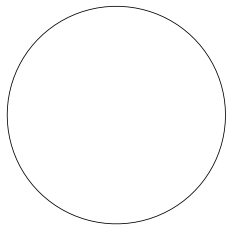

In [41]:
p = pyproj.Proj(da.rio.crs.to_proj4())

fig, ax = plt.subplots(subplot_kw=dict(projection=crs))

In [52]:
da.rio.crs

ERROR 1: PROJ: proj_identify: Cannot find proj.db


CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["GRS 1980",6378137,298.257222096042]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +sweep=x +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"]]')

In [53]:
crs = ccrs.CRS(da.rio.crs)
crs

<Derived Projected CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown", ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

ValueError: Expected a projection subclass. Cannot handle a <class 'cartopy.crs.CRS'> in imshow.

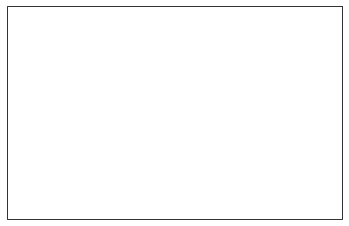

In [54]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.AzimuthalEquidistant()))

BBOX = [-60, -50, 11, 16]  # WESN

ax.set_extent(BBOX, crs=ccrs.PlateCarree())
da.plot.imshow(rgb="band", ax=ax, transform=crs)

ax.gridlines(draw_labels=True)
ax.coastlines(resolution="10m", color="red")

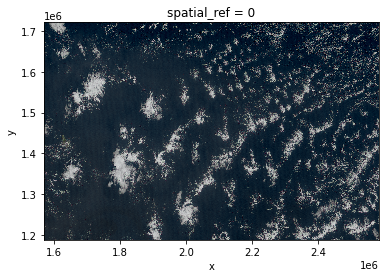

In [43]:
da.plot.imshow(rgb="band")

In [18]:
ccrs.Projection(da.rio.crs.to_proj4())

<Derived Projected CRS: +proj=geos +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +e ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep Y)
Datum: Unknown based on GRS80 ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Figure size 360x216 with 0 Axes>

In [19]:
ccrs.epsg('3857')

_EPSGProjection(3857)